In [2]:
# 加载需要的库
using ScikitLearn
using PyCall, Random, Statistics
using PyPlot, Printf
using ScikitLearn.CrossValidation: train_test_split
# 加载不同模型
@pyimport matplotlib.colors as mplc
@sk_import preprocessing: StandardScaler
@sk_import datasets: (make_moons, make_circles, make_classification) #加载数据集
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import tree: DecisionTreeClassifier
@sk_import ensemble: (RandomForestClassifier, AdaBoostClassifier)
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

In [3]:
h = .02  # step size in the mesh

# 定义分类器名称
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]

# 定义分类器，确定参数
classifiers = [
    KNeighborsClassifier(3), 
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
Random.seed!(42)
X += 2 * rand(size(X)...) # 对X进行随机变化
linearly_separable = (X, y) #生成新的数据集

# 三个数据集构成一个新的“集合”,加入noise
datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

3-element Array{Tuple{Array{Float64,2},Array{Int64,1}},1}:
 ([0.031595 0.986988; 2.1151 -0.046244; … ; -1.3185 0.423112; -1.29682 0.184147], [0, 1, 0, 1, 1, 1, 0, 1, 1, 1  …  1, 0, 0, 1, 0, 1, 1, 1, 0, 0])       
 ([-0.382891 -0.09084; -0.0209623 -0.477874; … ; 0.474405 1.01102; -0.385658 -0.810312], [1, 1, 0, 1, 1, 0, 0, 1, 1, 1  …  0, 0, 1, 1, 0, 1, 0, 1, 0, 0])
 ([0.0168796 1.1856; 1.78616 0.949819; … ; 1.23813 1.55829; 0.986005 3.32883], [1, 0, 0, 1, 1, 1, 0, 1, 0, 1  …  0, 1, 0, 0, 1, 0, 1, 1, 0, 1])          

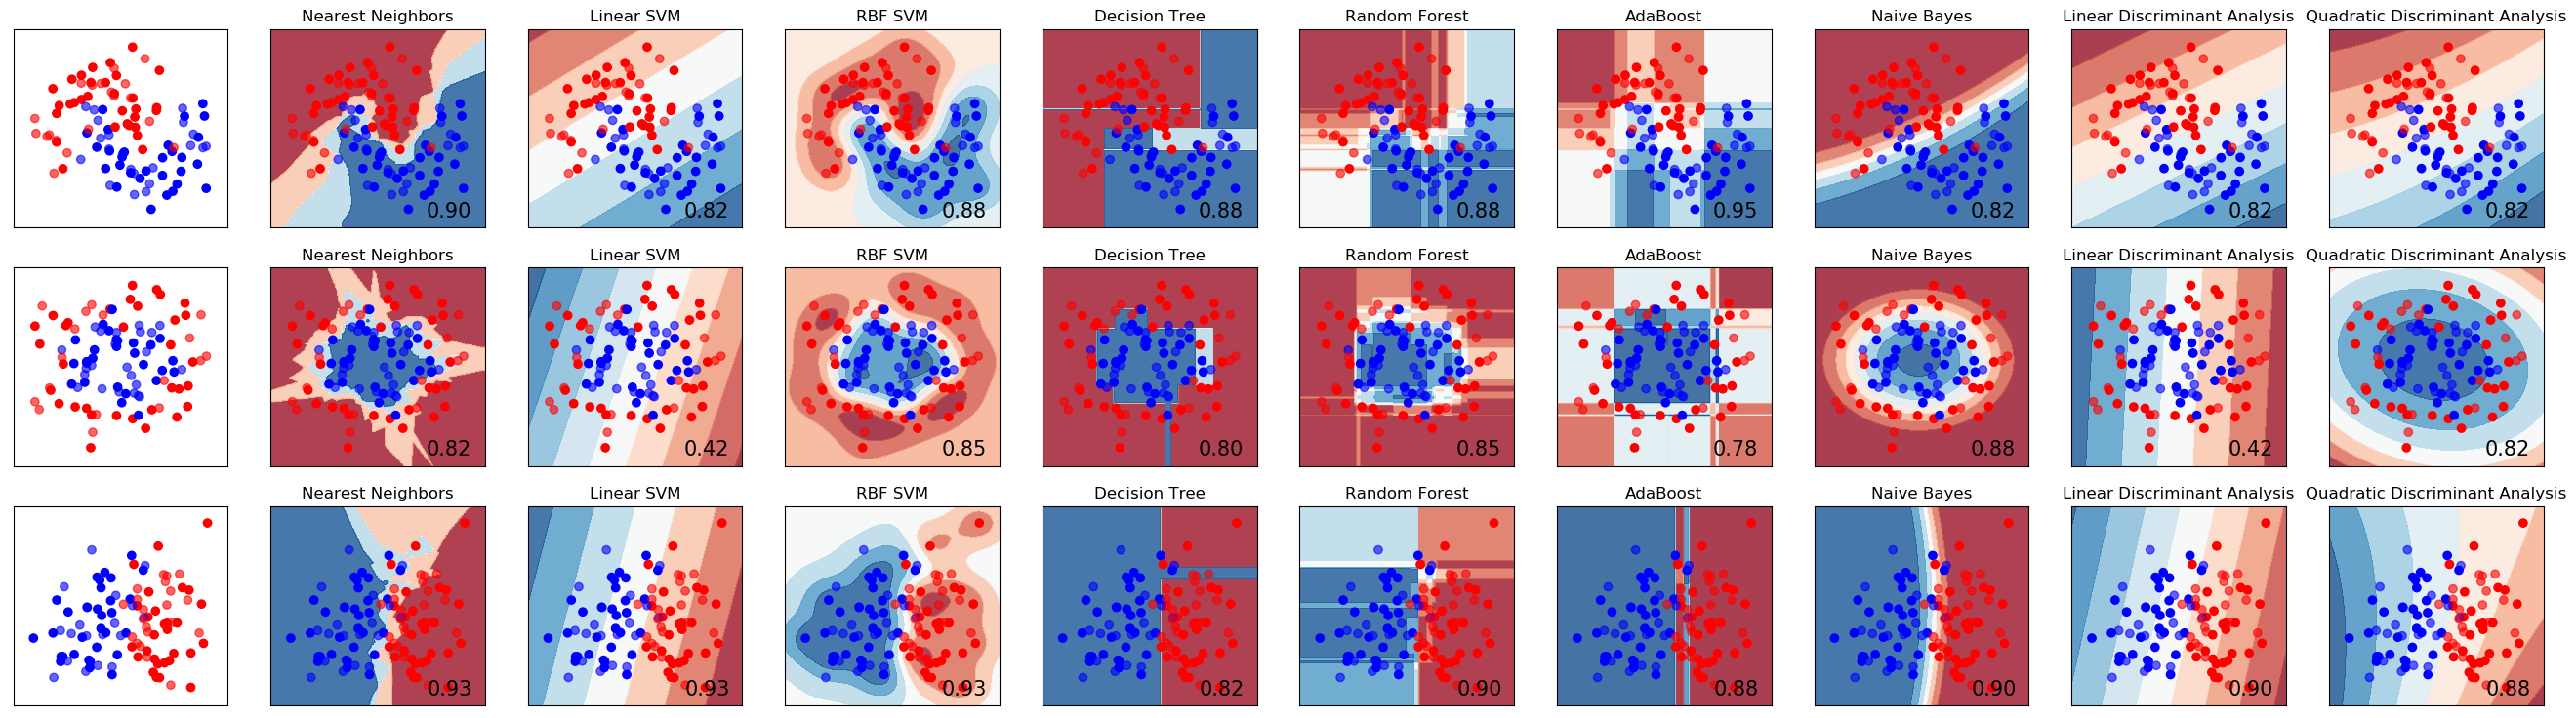

In [4]:
fig = figure(figsize=(27, 9))
i = 1
# 依次访问三个数据集，分别为make_moons,make_circles,linearly_sperarable
for ds in datasets
    # X为输入特征，y为标签
    local X, y = ds
    # 标准化数据，保证每个维度的特征数据方差为1，均值为0。使得预测结果不会被某些维度过大的特征值而主导。
    X = fit_transform!(StandardScaler(), X)
    # 划分训练集和测试集，test_size表示训练集占总数据集的比例
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    # 生成网格，每一个粒度为0.02，即h
    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # 先画数据集
    cm = PyPlot.cm[:RdBu]
    cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
    ax = subplot(length(datasets), length(classifiers) + 1, i)
    ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
    ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

    ax[:set_xlim](minimum(xx), maximum(xx))
    ax[:set_ylim](minimum(yy), maximum(yy))
    ax[:set_xticks](())
    ax[:set_yticks](())
    global i += 1

    # 遍历分类器
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers) + 1, i)
        fit!(clf, X_train, y_train)# 使用不同分类器进行拟合
        scor = score(clf, X_test, y_test)# 使用测试集进行测试

        #画出决策边界
        try 
            # Not implemented for some
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        # Put the result into a color plot
        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        # and testing points
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor),
                size=15, horizontalalignment="right")
        global i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)